# PROJECT OVERVIEW 

Given a 10,000 record data set of bank customers, build a classification model to predict which bank customers are mostly to churn

1. Profile & Explore the Data
   - Import the Bank_Churn.csv file and set an appropriate data type for each column
   - Check for missing values and calculate the min, max, and mean for numeric columns
   - Build a scatterplot matrix to find relationships between all pairs of numeric columns
   - Build box plots for each numeric column broken out by the target variable ('Exited')
   - Build bar charts that show the percentage of 'Exited' by category for each categorical column
2. Prepare the Data for Modeling
   - Drop columns that are not suitable for modeling from the data set
   - Create a new column 'balance_to_income' by dividing 'Balance' by 'EstimatedSalary'
   - Create a new column 'income_v_products' by dividing 'EstimatedSalary' by 'NumOfProducts'
   - Create dummy variables for categorical columns
   - Split the data into train and test sets, with 20% of the rows in the test set
3. Build & Evaluate a Logistic Regression Model
   - Fit a logistic regression model on the training data
   - Build a confusion matrix to evaluate the model
   - Calculate accuracy, precision, recall, and F1 for the test data
   - Plot an ROC curve and calculate the AUC statistic
   - Plot precision and recall against the model threshold (set the threshold to the value where recall is the highest, but precision is still above 50%)
4. Fit & Tune a Random Forest Model
   - Fit a random forest model with default hyperparameters
   - Use cross validation to tune the model's hyperparameters
   - Report the final test accuracy and AUC score
   - Build a bar chart that shows feature importance

**Final Project Question**

What is the mean of the 'balance_to_income' feature?

## LOAD THE DATA



In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


bank_df = pd.read_csv('Bank_Churn.csv')

bank_df.head()


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## DATA CLEANING

In [56]:
# check column dtypes and look for missing values
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


## INITIAL EDA

1. Build a scatterplot matrix to find relationships between all pairs of numeric columns
2. Build box plots for each numeric column broken out by the target variable (Exited)
3. Build bar charts that show the percentage of 'Exited' by category for each categorical column

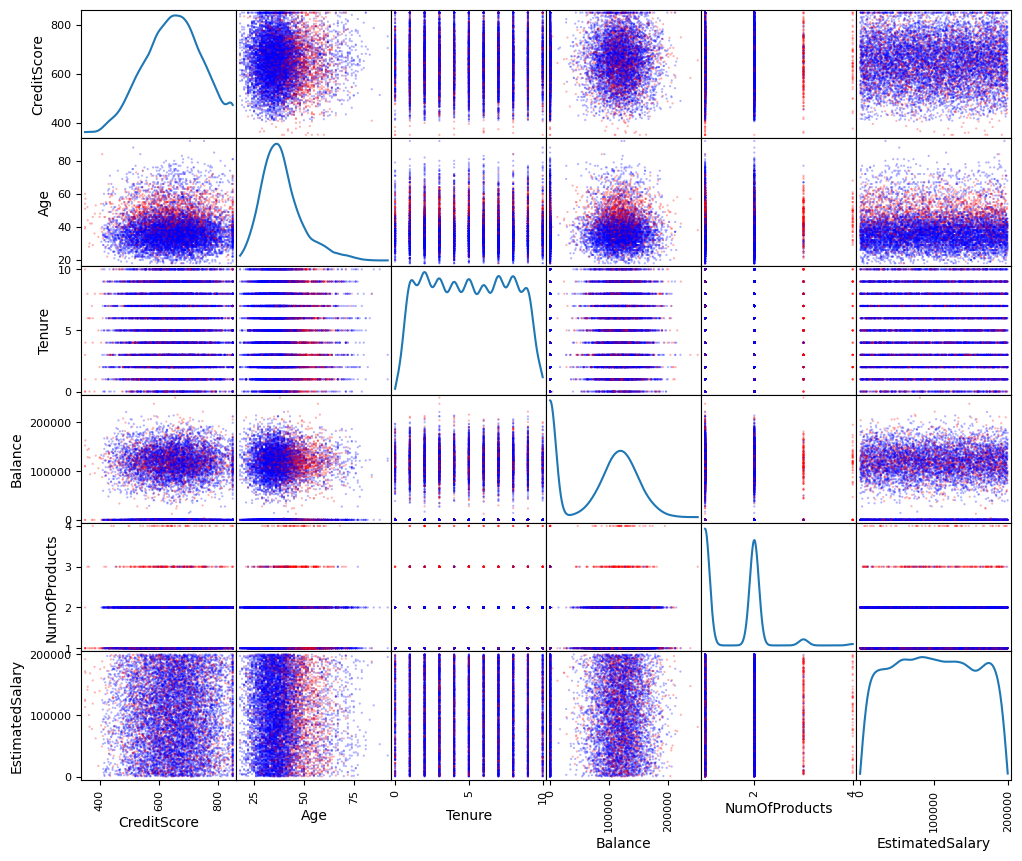

In [57]:
## Build a scatterplot matrix for all numeric columns
from pandas.plotting import scatter_matrix

# define the numeric columns
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# create a DataFrame with just the numeric columns
numeric_df = bank_df[numeric_cols]
# map colors to 'Exited'
colors = bank_df['Exited'].map({1: 'red', 0: 'blue'})
# Create scatterplot matrix
scatter_matrix(
    numeric_df, 
    alpha=0.3, 
    figsize=(12, 10), 
    diagonal='kde',
    c= colors,
    s=10)
# display the matrix
plt.show()

### SCATTERPLOT MATRIX OBSERVATIONS

- There is a distinct 'red shift' towards higher values on the axes whenever Age is one of the features.  This indicates that churn is heavily concentrated in the 40-60 age range.
- In plots that do not include Age in the comparison (CreditScore vs EstimatedSalary, etc.), the is no shift for either Churn or Non-Churn.  There is no visible separation between the classes.
- There also appear to be distinct patterns in NumOfProducts, where higher product counts show almost exclusive churn regardless of the other numeric values.

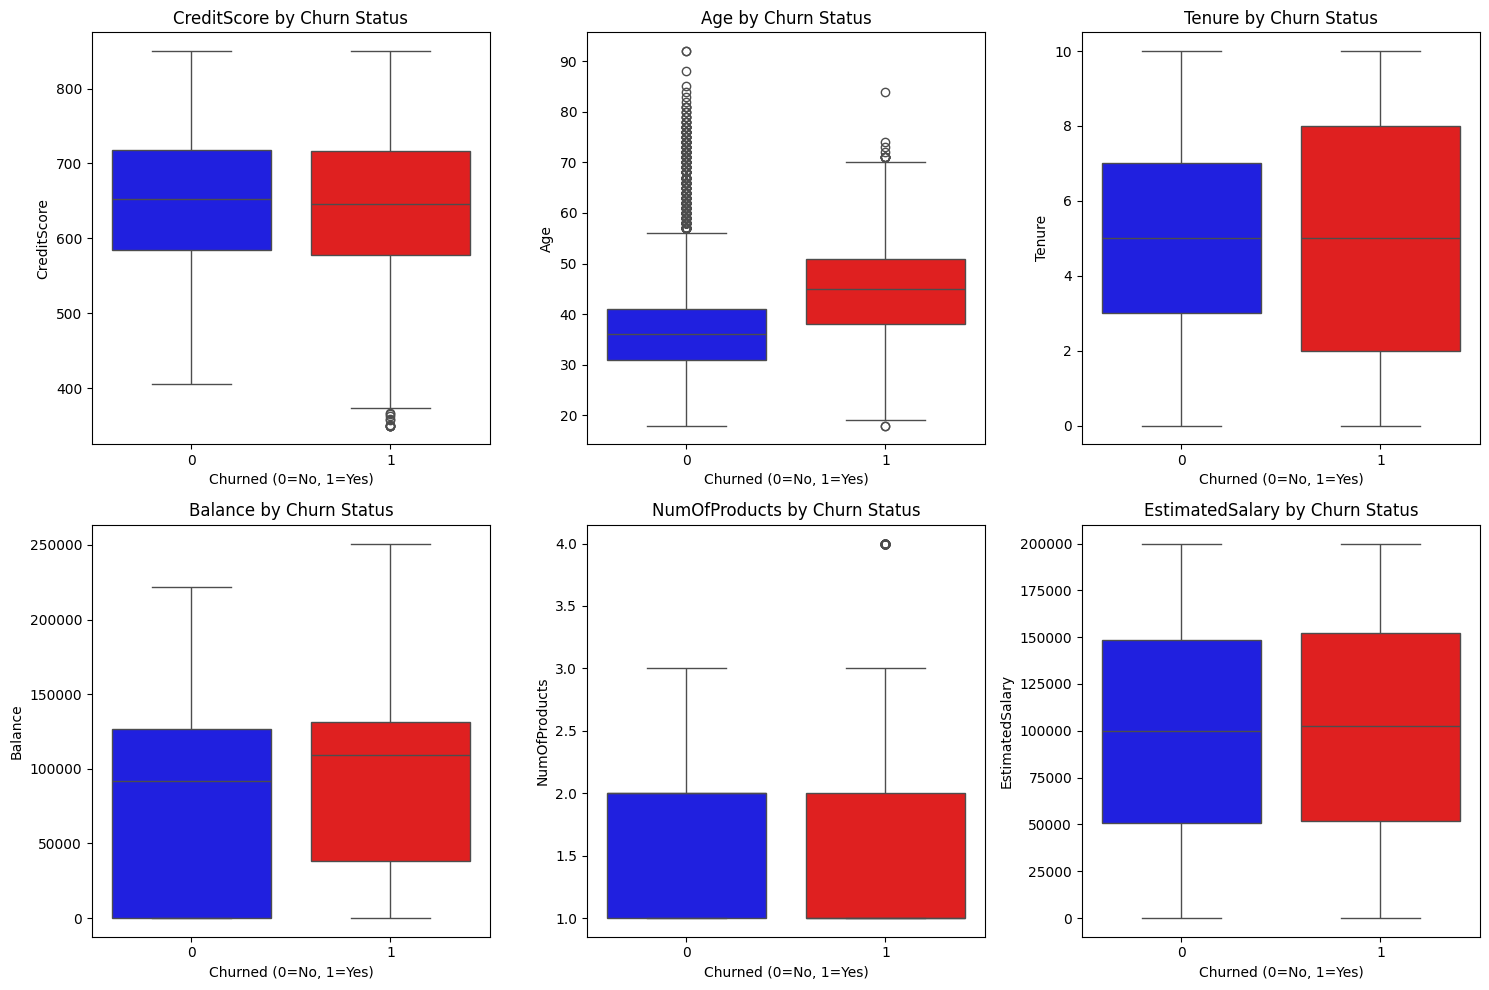

In [58]:
## Build box plots for each numeric column broken out by the target variable, 'Exited'
import matplotlib.pyplot as plt
# create the figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# flatten the axes
axes = axes.flatten()

# Loop through each numeric column and create a boxplot
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=bank_df, x='Exited', y=col, ax=axes[i], hue='Exited', palette={0: 'blue', 1: 'red'}, legend=False)
    axes[i].set_title(f'{col} by Churn Status')
    axes[i].set_xlabel('Churned (0=No, 1=Yes)')

# adjust and display
plt.tight_layout()
plt.show()

### BOXPLOT OBSERVATIONS

Observations on Age Feature
----------------------------
- The same observations concerning Age are confirmed in the boxplot.  The median age for churners is mid-40s, whereas for those customers who Stay it is mid-30s.  This is consistent with the red shift for customer over 40 years of age in the scatterplot matrix.
- The interquartile range for churners is higher than the median for those who Stay.  This indicates a systematic trend in the Age demographic (older customers churn far more than younger customers)
- There are numerous outliers above the boxplot for Stayed, indicating that while some older customers stay, they are the exception not the rule.

Observations on NumOfProducts Feature
-------------------------------------
- There is cluster of outliers above Churned at 4 Products.  This indicates that customers with 4 products almost always churn.  Customers with 2 or less products Churn vs Stay are level.

Observations on Balance Feature
-------------------------------
- The churn plot is slightly higher for Churners, indicating that customers with balances on the higher end, are slightly more likely to Churn
- The interquartile range is also narrower for Churn with a higher balance floor, suggesting that customers with lower balances are more likely to Stay.

Observations on Estimated Salary Feature
-----------------------------------------
- similar to Balance, the Churn plot for EstimatedSalary is shifted slightly higher than Stay, indicating that more affluent customers are slightly more likely to churn.

Observations on Tenure Feature
------------------------------
- The distribution for Churn is larger than Stay, indicating longer-tenured and newer customers are more likely to churn, then customers closer the tenure median (4-6 years).

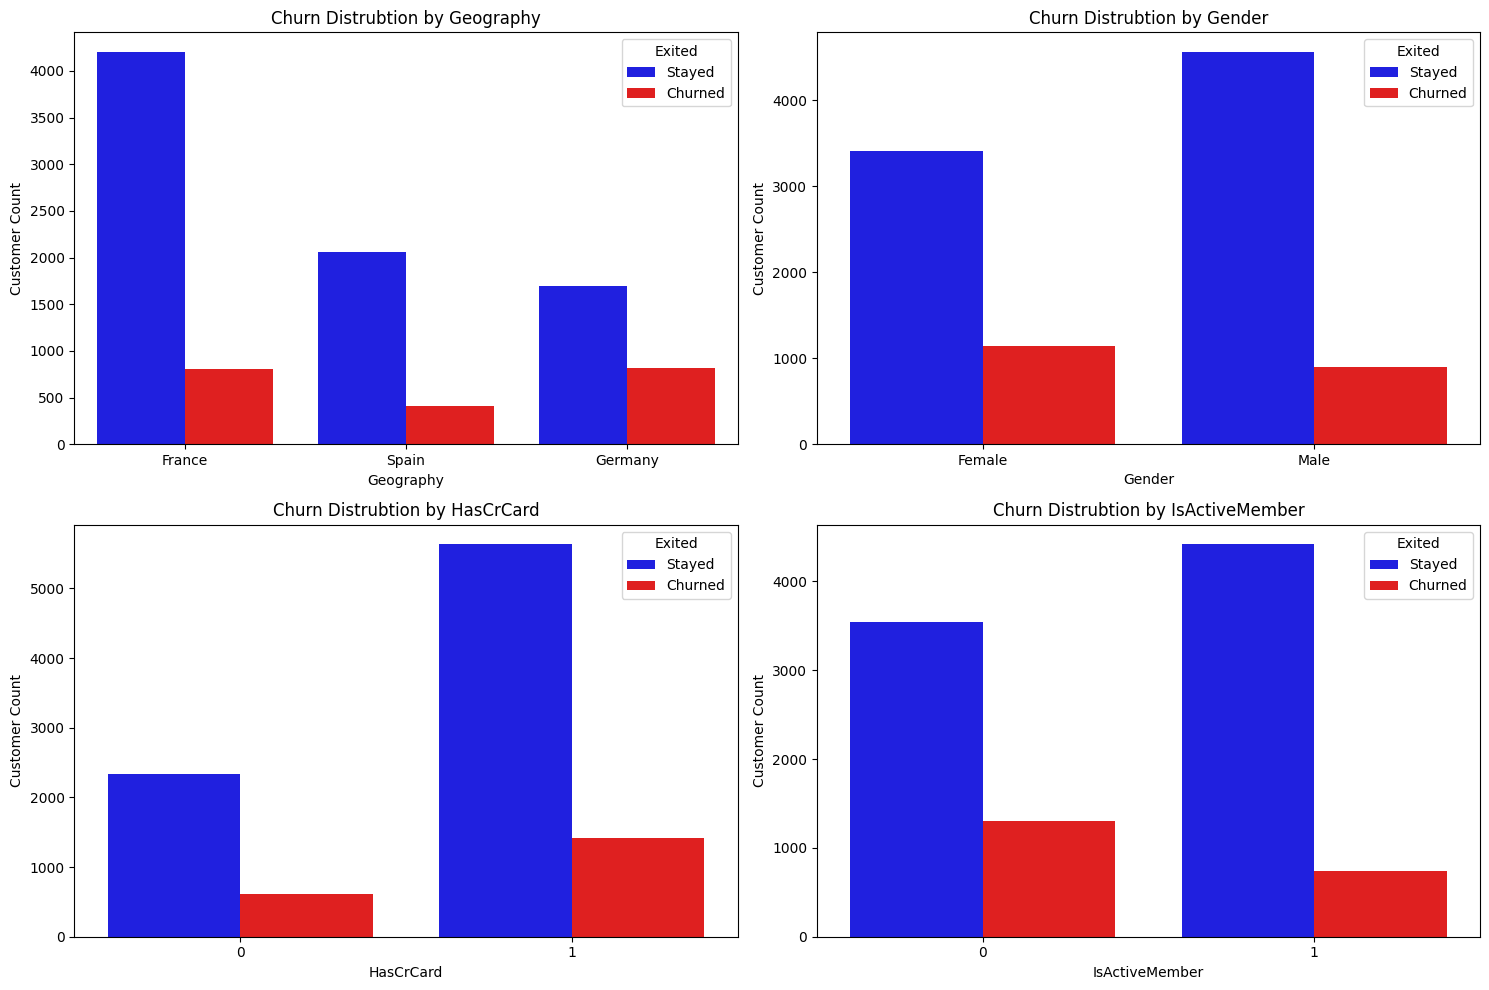

In [60]:
## Build bar charts that show the percentage of 'Exited' by category for each categorical column

# create a list of the categorical columns
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

# create the figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# flatten the axes
axes = axes.flatten()

# Loop through each categorical column and create bar chart
for i, col in enumerate(cat_cols):
    sns.countplot(data=bank_df, x=col, ax=axes[i], hue='Exited', palette={0: 'blue', 1: 'red'})
    axes[i].set_title(f'Churn Distrubtion by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Customer Count')
    axes[i].legend(title='Exited', labels=['Stayed', 'Churned'])

# adjust and display
plt.tight_layout()
plt.show()

### BAR CHART OBSERVATIONS

Regional Observations
---------------------
- French customers show significant loyalty with high tendency to Stay
- German customers have an alarming rate of churn compared to Spain and France.  The German churn rate is disproportinate relative to its total customer base.
- Due to this clear regional disparity, Geography would an excellent feature to use in modeling

Gender Observations
-------------------
- males are more likely to stay than females as there is significantly narrower gap between Churn-Stay in the female class
- Gender would be an ideal feature for modeling 

Credit Card Ownership Observations
----------------------------------
- owning a credit card indicates a stronger likelihood to stay, but also has a slightly higher churn rate.  This is most likely due to a higher population in the Has credit card class, creating slightly more instances of Churn.  
- The ratio of Stay to Churn looks fairly similar across classes, indicating HasCrCard is likely not a strong feature for modeling, compared to Gender or Geography

Membership Status Observations
------------------------------
- being an active member indicates a strong correlation with Stay
- since being an active member has a strong negative correlation with churn, this would be a strong feature for modeling

## FEATURE SELECTION & ENGINEERING

1. drop columns that are not suitable for modeling (CustomerId, Surname, HasCrCard)
2. create new features: 'balance_to_income' and 'income_v_products'
   - balance_to_income measures a customer's financial commitment to the bank.  A customer with a high percentage of their estimated income invested with the bank signifies a strong commitment to the bank, and vice versa.
   - income_v_products measures the customers product stress.  A lower income customer with a higher number of products may feel more encumbered by fees, whereas a high income customer with a lower number of products may be an ideal candidate for upselling.  The first instance may be a high risk to churn, whereas the second instance, if handled correctly, may be more loyal, longer-tenured customer.  This will help to catch non-linear interactions between wealth and service usage, enhancing the predictive capabilities of the model.
3. Create dummy variables for Geography and Gender

In [61]:
# drop unnecessary columns
bank_df = bank_df.drop(columns=['CustomerId', 'Surname', 'HasCrCard'])

bank_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


In [62]:
# create balance_to_income feature
bank_df['balance_to_income'] = bank_df['Balance'] / bank_df['EstimatedSalary'] 

# create income_v_products feature
bank_df['income_v_products'] = bank_df['EstimatedSalary'] / bank_df['NumOfProducts']

bank_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,balance_to_income,income_v_products
0,619,France,Female,42,2,0.00,1,1,101348.88,1,0.000000,101348.880
1,608,Spain,Female,41,1,83807.86,1,1,112542.58,0,0.744677,112542.580
2,502,France,Female,42,8,159660.80,3,0,113931.57,1,1.401375,37977.190
3,699,France,Female,39,1,0.00,2,0,93826.63,0,0.000000,46913.315
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0,1.587055,79084.100


In [63]:
# create dummy variables for Geography and Gender

bank_df = pd.get_dummies(bank_df, columns=['Geography', 'Gender'], drop_first=True)

bank_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,balance_to_income,income_v_products,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,101348.88,1,0.000000,101348.880,False,False,False
1,608,41,1,83807.86,1,1,112542.58,0,0.744677,112542.580,False,True,False
2,502,42,8,159660.80,3,0,113931.57,1,1.401375,37977.190,False,False,False
3,699,39,1,0.00,2,0,93826.63,0,0.000000,46913.315,False,False,False
4,850,43,2,125510.82,1,1,79084.10,0,1.587055,79084.100,False,True,False


## DATA SPLITTING


In [64]:
from sklearn.model_selection import train_test_split

# define the target variable
y = bank_df['Exited']
# define features
X = bank_df.drop('Exited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the data  due to disparity in some features (e.g. Age and EstimatedSalary on different scales)
from sklearn.preprocessing import StandardScaler

# initialize the scaler
scaler = StandardScaler()

# fit and transform training data
X_trained_scaled = scaler.fit_transform(X_train)

# transform the test data
X_test_scaled = scaler.transform(X_test)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (8000, 12)
X_test shape: (2000, 12)
y_train shape: (8000,)
y_test shape: (2000,)


## FIT AND TRAIN LOGISTIC REGRESSION MODEL


In [65]:
from sklearn.linear_model import LogisticRegression

# define model, balance class due to importance of minority class (Churners)
log_reg = LogisticRegression(class_weight = 'balanced', random_state=42)

log_reg.fit(X_trained_scaled, y_train)

# Verify learned target classes
print(f'Model Classes: {log_reg.classes_}')
# Verify the model converged properly
print(f'Iterations taken: {log_reg.n_iter_[0]}')
# Check coefficients for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Model Classes: [0 1]
Iterations taken: 10
              Feature  Coefficient
8   income_v_products     1.113992
1                 Age     0.807555
4       NumOfProducts     0.425694
9   Geography_Germany     0.343945
3             Balance     0.144470
10    Geography_Spain     0.048184
7   balance_to_income     0.017803
2              Tenure    -0.033115
0         CreditScore    -0.070998
11        Gender_Male    -0.271731
5      IsActiveMember    -0.459303
6     EstimatedSalary    -0.944758


### FEATURE IMPORTANCE OBSERVATIONS

- coefficient scoring aligns well with assumptions held prior to model training
- income_v_products, age, germany were all thought to correlate strongly with likelihood to churn, which is validated in this coefficient scoring.  Being an active member, male gender negatively correlate to churn which were also assumed prior to training

## SCORE AND EVALUATE MODEL

1. build a confusion matrix to evaluate the model
2. calculate accuracy, precision, recall and F1 for the test data
3. plot an ROC curve and calculate the AUC statistic
4. plt precision and recall against the model threshold (set the threshold to the value where recall is the highest, but precision is still above 50%)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# generate predictions using the scaled test data
y_pred = log_reg.predict(X_test_scaled)

# display the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1607
           1       0.38      0.73      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.74      2000



Confusion Matrix


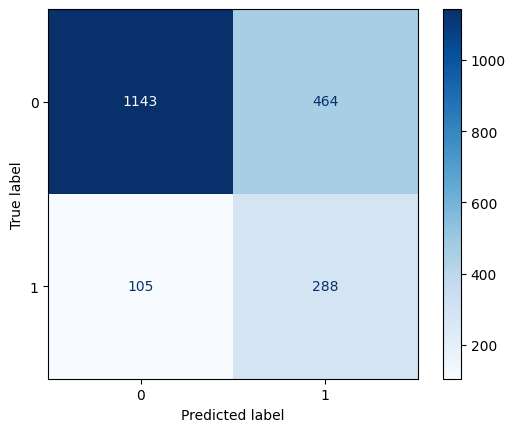

In [67]:
# Plot the confusion matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.show()

### CLASSIFICATION REPORT AND CONFUSION MATRIX OBSERVATIONS

Classification Report
---------------------
- Recall (0.73): the model correctly identified 73% of all customers who left.  This means the bank would successfully catch 3 out of 4 possible churners before they exit.
- Precision of 0.38 indicates the model is flagging a high percentage of customers as likely to churn, when in reality they are not.  This is due to the class_weight balancing favoring the minority class more than normal.  However, this is an acceptable trade-off due to the high importance of identifying churners prior to churning.
- an F1 score of 0.50 further supports the previous claim.  It indicates that while the model predicts a good amount of false alarm churners, this does not outweight the benefit capturing a large amount of true churners successfully

Confusion Matrix
-----------------
- True Positives were 288 and False Positives were 464.  Further supports the claim that the model is over flagging possible churners.
- False Negatives were 105 and True Negatives were 1143. The model correctly identified 1143 customers as loyal.
- The model identified churners at an almost 2:1 rate (True + 288: False - 105).  Highly beneficial for customer retention

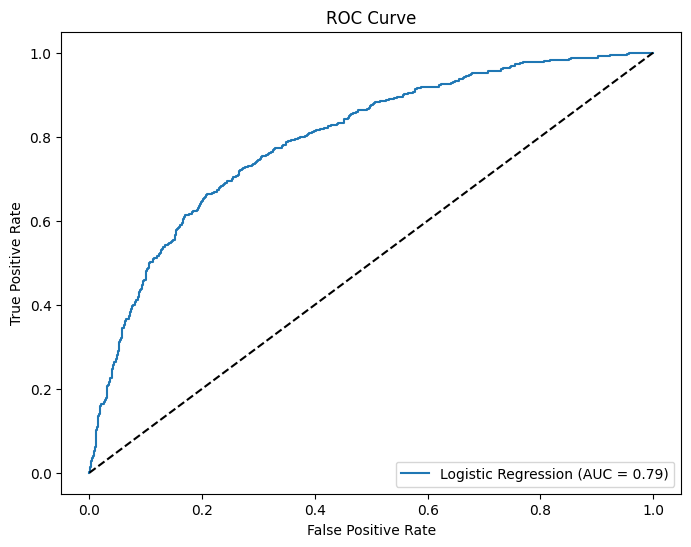

Final AUC Score: 0.79


In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

# get probability estimates for the positive class (Churned)
y_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Final AUC Score: {auc_score:.2f}')
         

### ROC CURVE AND AUC SCORE OBSERVATIONS

The model achieved an AUC of 0.79, indicating a strong propensity to discriminate between churners and non-churners (retained customers).  The ROC curve stays well aboves the baseline (dashed line), confirming that the model provides significant predictive value of random guessing (the baseline).

## FIT AND TUNE RANDOM FOREST MODEL

1. fit Random Forest with default hyperparameters
2. use cross validation to tune the model's hyperparameters
3. report the final test accuracy and AUC score
4. build a bar chart that shows feature importance

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Random Forest AUC: 0.87
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1607
           1       0.58      0.66      0.62       393

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.85      0.84      0.84      2000



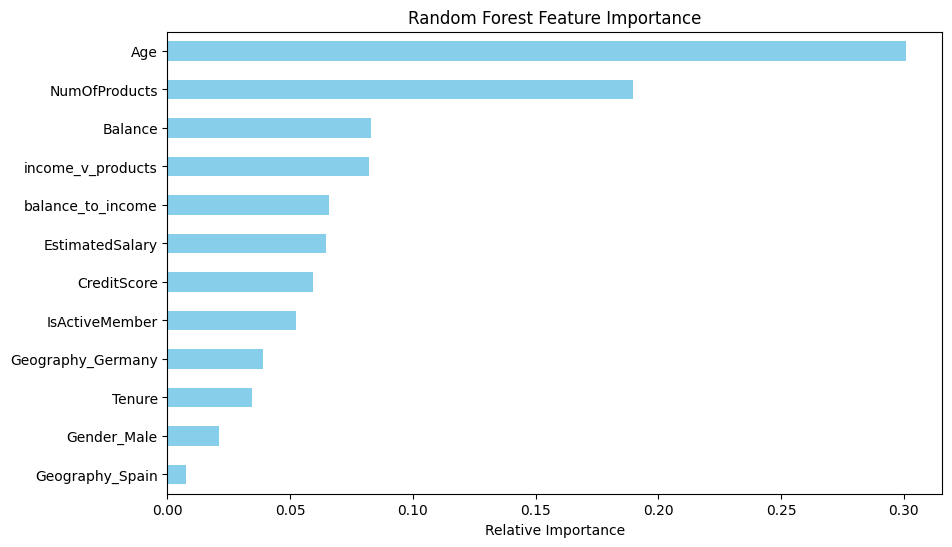

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# initialize and fit baseline Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# hyperparameter tuning 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
cv_rf.fit(X_trained_scaled, y_train)
best_rf = cv_rf.best_estimator_

# results
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
print(f'Best Parameters: {cv_rf.best_params_}')
print(f'Random Forest AUC: {roc_auc_score(y_test, y_prob_rf):.2f}')
print(classification_report(y_test, y_pred_rf))

# feature importance bar chart
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

### RANDOM FOREST OBSERVATIONS

The Random Forest model achieved a superior AUC of 0.87 compared the Logistic Regression model.  While LR was better at raw Recall, the Random Forest provides a more balanced and precise approach, reducing the False Positives (Precision: 0.58).  Age and NumOfProducts are the strongest drivers of churn, per the feature importance results.  

## FINAL PROJECT SUMMARY: BANK CUSTOMER CLASSIFICATION

Project Objective
------------------
The goal of this project was to build a predictive model that identifies customers at high risk of churning. Given the business context, the primary focus was on achieving high recall for the minority class (churners) while maintaining a high AUC to ensure strong separation between classes.

Model Performance and Selection
--------------------------------
Two models were evaluated: Logistic Regression (LR) and Random Forest (RF).

**Logistic Regression**: Served as a strong baseline, achieving an AUC of 0.79. By utilizing balanced class weights, this model prioritized the detection of churners, identifying roughly 3 out of 4 possible exits.

**Random Forest**: This model provided the best overall performance with an AUC of 0.87. While it had slightly lower recall than the LR model, it significantly improved Precision to 0.58, meaning it was far more efficient at identifying true churners without over-flagging loyal customers.

Key Predictors of Churn
-------------------------
The Feature Importance analysis identified the following primary drivers:

**Age**: Remained the single most influential factor in customer exit.

**NumOfProducts**: Ranked as the second most important feature, suggesting that product density significantly impacts stickiness or friction.

**Engineered Features**: My custom feature, income_v_products, ranked in the top four predictors for the Random Forest. This validates the initial hypothesis that the ratio of a customer's income to their bank engagement is a vital indicator of risk.

Business Conclusion
-------------------
The Random Forest model is the recommended solution for deployment. With an AUC of 0.87, the bank can accurately rank customers by risk level. This allows the marketing and retention teams to prioritize high-risk segments—specifically older customers and those with specific product counts—with targeted interventions, ultimately reducing churn costs and preserving lifetime customer value.